In [1]:
import GCRCatalogs
import numpy as np
from astropy.table import Table
from GCR import GCRQuery
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
cats=GCRCatalogs.get_available_catalogs()
cats.keys()

dict_keys(['buzzard', 'buzzard_high-res', 'cosmoDC2_v1.1.4_image', 'cosmoDC2_v1.1.4_redmapper_v0.8.1', 'cosmoDC2_v1.1.4_small', 'dc2_object_run1.2i', 'dc2_object_run1.2i_all_columns', 'dc2_object_run1.2i_tract4850', 'dc2_object_run1.2i_with_photoz', 'dc2_object_run1.2p', 'dc2_object_run1.2p_all_columns', 'dc2_object_run1.2p_tract4850', 'dc2_object_run2.2i_dr2_wfd', 'dc2_object_run2.2i_dr2_wfd_with_addons', 'dc2_object_run2.2i_dr3a', 'dc2_object_run2.2i_dr3a_with_metacal', 'dc2_object_run2.2i_dr3a_with_photoz', 'dc2_object_run2.2i_dr6', 'dc2_object_run2.2i_dr6_with_addons', 'dc2_redmapper_run2.2i_dr6_wfd_v0.8.1', 'dc2_truth_run1.2_static', 'dc2_truth_run1.2_variable_lightcurve', 'dc2_truth_run1.2_variable_summary', 'dc2_truth_run2.2i_galaxy_truth_summary', 'dc2_truth_run2.2i_sn_truth_summary', 'dc2_truth_run2.2i_sn_variability_truth', 'dc2_truth_run2.2i_star_lc_stats', 'dc2_truth_run2.2i_star_truth_summary', 'dc2_truth_run2.2i_star_variability_truth', 'dc2_truth_run2.2i_summary_tract_pa

## Start the work by getting the catalogs

In [3]:
# gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
cols=gc.list_all_quantities()
scols= []
scols.append([x for x in cols if 
              (not x.startswith("sed")) and 
              (not x.endswith("no_host_extinction")) and 
              (not x.startswith("ellipticity")) and
              (not x.startswith("size"))
             ])

#print('\n'.join(sorted(scols[0])))

In [4]:
#galaxy_data = gc.get_quantities(['ra', 'dec', "redshift", "stellar_mass", 
#                                 "mag_u_lsst", "mag_g_lsst", "mag_r_lsst", "mag_i_lsst", "mag_z_lsst",
#                                 'halo_id', 'halo_mass', 'is_central'], 
#                                 filters=['mag_r < 23', 'Mag_true_r_lsst_z0 < -19.0'])
#


In [5]:
cluster_data = gc.get_quantities(['ra','dec', "redshift", 'stellar_mass', 'halo_mass', 'halo_id'], 
                                 filters=['is_central', 'halo_mass > 1e13', 'redshift >= 0.2', 'redshift < 0.7'])
cluster_data = pd.DataFrame(cluster_data)
cluster_data["central_sm"] = cluster_data["stellar_mass"]
cluster_data = cluster_data.drop(columns="stellar_mass")

In [6]:
#print("galaxies", len(galaxy_data), type(galaxy_data), galaxy_data["ra"].size)
print("n clusters:", len(cluster_data))
#sns.scatterplot(x=cluster_data["ra"],y=cluster_data["dec"])
print("cluster masses {:.2f} - {:.2f}".format( 
    np.log10(cluster_data["halo_mass"].min()),np.log10(cluster_data["halo_mass"].max())))

n clusters: 90030
cluster masses 13.00 - 15.18


In [7]:
galaxy_data = gc.get_quantities(['ra', 'dec', "redshift", "stellar_mass", 
                "mag_u_lsst", "mag_g_lsst", "mag_r_lsst", "mag_i_lsst", "mag_z_lsst",
                'halo_id', 'halo_mass', 'is_central'], 
                filters=['mag_r < 23', 'Mag_true_r_lsst_z0 < -19.0'])

In [8]:
galaxy_data = pd.DataFrame(galaxy_data)
print(galaxy_data.shape)

try:
   import cPickle as pickle
except:
   import pickle

#pickle.dump(galaxy_data,open("big_galaxy_cat.picle","wb"))
galaxy_data pickle.load(open("big_galaxy_cat.picle","rb"))

SyntaxError: invalid syntax (3335827991.py, line 10)

## Get and process the galaxies around the clusters

In [40]:
def cutout_around_cluster (galaxy_data, radius_arcmin, ra,dec, halo_id, halo_mass, halo_z) :
    radius=radius_arcmin/60.
   # ix, = np.where((np.abs(galaxy_data["dec"]-dec)<radius) & 
   #              (np.abs(galaxy_data["ra"]-ra)<radius/np.cos(dec*2*np.pi/360.)) )

    galaxy_data = galaxy_data[ 
        galaxy_data["dec"] > dec-radius & galaxy_data["dec"] <= dec+radius &
        galaxy_data["ra"] > ra - radius/np.cos(dec*2*np.pi/360.) &
        galaxy_data["ra"] <= ra + radius/np.cos(dec*2*np.pi/360.)]                                      
                    
    new_df = pd.DataFrame(
            {"ra":gdata["ra"],"dec":galaxy_data["dec"],
             "redshift":galaxy_data["redshift"],
             "stellar_mass":galaxy_data["stellar_mass"],
             "mag_i":galaxy_data["mag_i_lsst"],
             "mag_u-g":galaxy_data["mag_u_lsst"]-galaxy_data["mag_g_lsst"],
             "mag_g-r":galaxy_data["mag_g_lsst"]-galaxy_data["mag_r_lsst"],
             "mag_r-i":galaxy_data["mag_r_lsst"]-galaxy_data["mag_i_lsst"],
             "mag_i-z":galaxy_data["mag_i_lsst"]-galaxy_data["mag_z_lsst"],
             "halo_id":galaxy_data["halo_id"],
             "cluster_id":(np.ones(galaxy_data["halo_id"].size)*halo_id).astype(int),
             "cluster_mass":(np.ones(galaxy_data["halo_id"].size)*halo_mass),
             "cluster_z":(np.ones(galaxy_data["halo_id"].size)*halo_z)
            })
    return new_df


### Create galaxy catalog around each cluster to a specified radius

In [36]:
def all_cutout_around_cluster (cluster_data, gc, radius_mpc) :
    list=[]
    for cl_idx in range(0,cluster_data["ra"].size): 
        ra = cluster_data["ra"].iloc[cl_idx]
        dec = cluster_data["dec"].iloc[cl_idx];
        halo_id = cluster_data["halo_id"].iloc[cl_idx]
        halo_mass = cluster_data["halo_mass"].iloc[cl_idx] 
        halo_z = cluster_data["redshift"].iloc[cl_idx]
        # bins:  0.2-0.3, 0.3-0.4, 0.4-0.6 0.6-0.7
        arcmin_mpc = redshift_to_bin_arcmin_mpc(halo_z)
        radius_arcmin = radius_mpc * arcmin_mpc # mpc * arcmin/mpc
        list.append(cutout_around_cluster (gc, radius_arcmin, ra,dec, halo_id, halo_mass, halo_z ))
    gal_df = pd.concat(list, ignore_index=True) # concat all cluster df into one single gal_cat df
    return gal_df

def redshift_to_bin_arcmin_mpc (halo_z) :
    # bins:  0.2-0.3, 0.3-0.4, 0.4-0.6 0.6-0.7
    if halo_z <0.3:
        arcmin_mpc =  6.1
    elif ( (halo_z>= 0.3) & (halo_z< 0.4)) :
        arcmin_mpc =  4.8
    elif ( (halo_z>= 0.4) & (halo_z< 0.6)) :
        arcmin_mpc=  3.9
    elif halo_z>= 0.6 :
        arcmin_mpc =  3.5
    return arcmin_mpc

###  Produce the giant galaxy dataframe

In [ ]:
#galaxy_data = gc.get_quantities(['ra', 'dec', "redshift", "stellar_mass", 
#                "mag_u_lsst", "mag_g_lsst", "mag_r_lsst", "mag_i_lsst", "mag_z_lsst",
#                'halo_id', 'halo_mass', 'is_central'], 
#                filters=['mag_r < 23', 'Mag_true_r_lsst_z0 < -19.0']

radius_mpc=3.
gal_df = all_cutout_around_cluster(cluster_data, gc, radius_mpc)

print(gal_df.size)
#gal_df

#### Let's save this giant file to disk

In [ ]:
print(!pwd)
#gal_df.to_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
gal_df.to_csv("Data/galaxies_near_clusters_0.2-0.7_image.csv") 

### Add a series of stellar masses to the cluster catalog¶

In [ ]:
# test a single cluster
radius_arcmin=33.
for i in range(0,1) :
    ra=cluster_data["ra"].iloc[i]; dec=cluster_data["dec"].iloc[i]; halo_id = cluster_data["halo_id"].iloc[i]
    halo_mass = cluster_data["halo_mass"].iloc[i];  halo_z = cluster_data["redshift"].iloc[i]
    df=cutout_around_cluster (galaxy_data, radius_arcmin, ra,dec, halo_id, halo_mass, halo_z) 
    df2 = df[df["halo_id"]== df["cluster_id"]]
    stellarmass = df2["stellar_mass"].sum()
    print(np.log10(stellarmass), np.log10(cluster_data["halo_mass"].iloc[i]))
    print (10**(np.log10(cluster_data["halo_mass"].iloc[i])-np.log10(stellarmass) ))
df2

## Code to add the stellar masses

These are cylindrical masses- the on-sky axes are cut to 1 Mpc or varient, but perp-sky direction contains all members

In [26]:
# given raw galaxy_data and cluster_data, add a series of stellar masses to cluster_data
def stellarmass_to_cat(cluster_data, galaxy_data) :
    rad_list = np.array( [0.5, 0.67, 1.0, 1.5, 2, 3, 10]) # mpc
    name_list = ["sm_0.50","sm_0.67", "sm_1.0", "sm_1.5", "sm_2.0", "sm_3.0", "stellarmass"]
    if (len(rad_list) != len(name_list)) : 
        raise Exception("radius and names !same length")    
    for radius, name in zip(rad_list,name_list) :
        print(name, radius)
        sm = []
        for i in range(0,cluster_data["halo_id"].size) :
            ra=cluster_data["ra"].iloc[i]; 
            dec=cluster_data["dec"].iloc[i]; 
            halo_id = cluster_data["halo_id"].iloc[i]
            halo_mass = cluster_data["halo_mass"].iloc[i];  
            halo_z = cluster_data["redshift"].iloc[i]
            # bins:  0.2-0.3, 0.3-0.4, 0.4-0.6 0.6-0.7
            arcmin_mpc = redshift_to_bin_arcmin_mpc(halo_z)
            radius_arcmin = radius * arcmin_mpc # mpc * arcmin/mpc
        
            df=cutout_around_cluster (galaxy_data, radius_arcmin, ra,dec, halo_id, halo_mass, halo_z) 
            match_df = df[df["halo_id"] == df["cluster_id"]]
            stellarmass = match_df["stellar_mass"].sum()
            sm.append(stellarmass)
        sm=np.array(sm)
        cluster_data[name] = sm
    return cluster_data
         


In [ ]:
df=stellarmass_to_cat(cluster_data, galaxy_data)
df

In [17]:
cluster_data["halo_mass"] = np.log10(cluster_data["halo_mass"])
cluster_data["stellarmass"] = np.log10(cluster_data["stellarmass"])
cluster_data["central_sm"] = np.log10(cluster_data["central_sm"])
cluster_data["sm_0.50"] = np.log10(cluster_data["sm_0.50"])
cluster_data["sm_0.67"] = np.log10(cluster_data["sm_0.67"])
cluster_data["sm_1.0"] = np.log10(cluster_data["sm_1.0"])
cluster_data["sm_1.5"] = np.log10(cluster_data["sm_1.5"])
cluster_data["sm_2.0"] = np.log10(cluster_data["sm_2.0"])
cluster_data["sm_3.0"] = np.log10(cluster_data["sm_3.0"])

### Let's save the cluster file to disk

In [18]:
!pwd

/global/u1/a/annis


In [19]:
print(!pwd)
cluster_data.to_csv("Data/cluster_data_0.3-0.6.csv")

### And let's explore the data

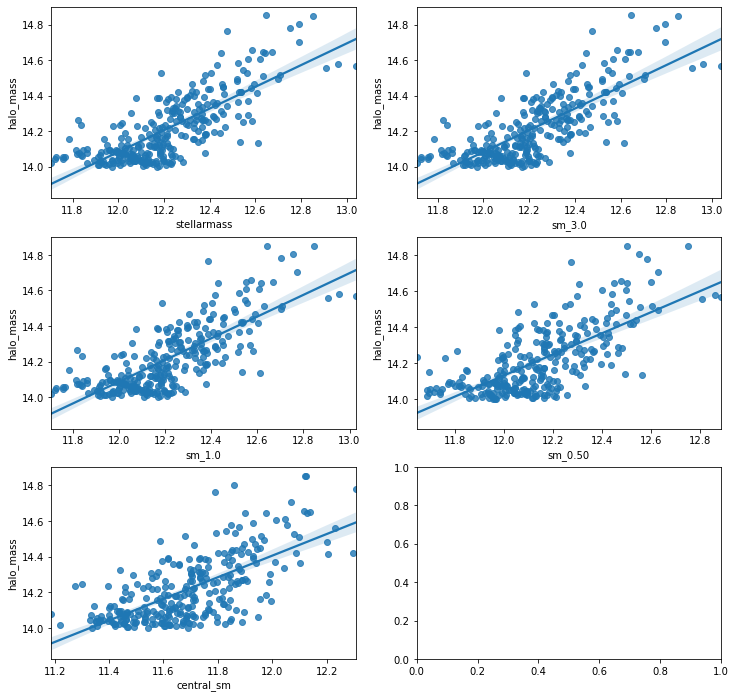

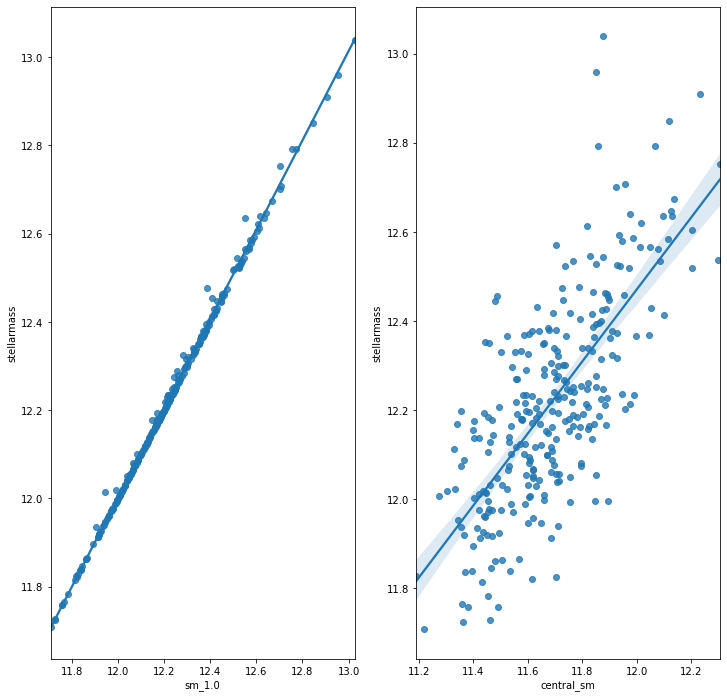

In [23]:
fig, ax = plt.subplots(3,2, figsize=(12, 12))
for var, subplot in zip(["stellarmass","sm_3.0","sm_1.0","sm_0.50", "central_sm"], ax.flatten()):
    sns.regplot(x = var, y = "halo_mass", data = cluster_data, ax = subplot);
fig, ax = plt.subplots(1,2, figsize=(12, 12))
for var, subplot in zip(["sm_1.0", "central_sm"], ax.flatten()):
    sns.regplot(x=var,y="stellarmass", data=cluster_data, ax=subplot)


<AxesSubplot:xlabel='stellarmass'>

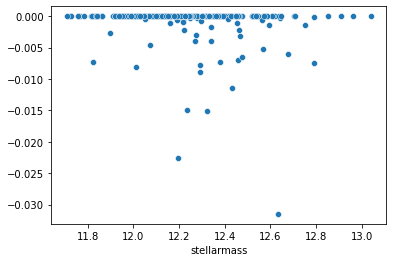

In [18]:
sns.scatterplot(x=cluster_data["stellarmass"],y=cluster_data["sm_1.5"]-cluster_data["stellarmass"])

If one wanted to do spherical instead of cylindrical, one would have to use x,y,z of central and members

<AxesSubplot:ylabel='Count'>

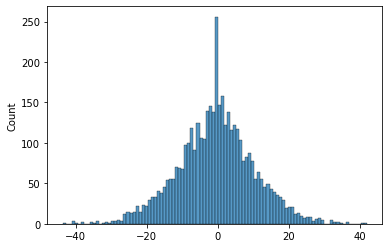

In [17]:
sns.histplot((gal_df[gal_df["halo_id"]==
                     gal_df["cluster_id"]]["redshift"]-gal_df[gal_df["halo_id"]==gal_df["cluster_id"]]["cluster_z"])*3.0e5/70.
             ,bins=100)


<AxesSubplot:ylabel='Count'>

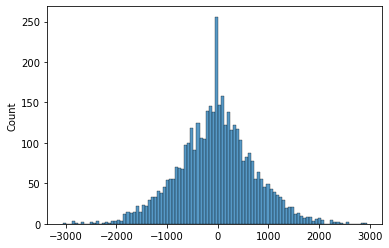

In [18]:
sns.histplot((gal_df[gal_df["halo_id"]==
                     gal_df["cluster_id"]]["redshift"]-gal_df[gal_df["halo_id"]==gal_df["cluster_id"]]["cluster_z"])*3.0e5
             ,bins=100)